In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
from keras.models import Model 
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose


2025-10-02 16:22:34.645808: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-02 16:22:34.673354: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-02 16:22:34.886417: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-02 16:22:35.060030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759443755.218691   26793 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759443755.26

In [2]:
#Define the following variables

(x_train, _), (x_test, _) = fashion_mnist.load_data()

X_train = x_train.astype('float32') / 255.
X_test = x_test.astype('float32') / 255.
	
input_dim = (28,28,1)
latent_dim = (7,7,1)
output_dim = (28,28,1)

In [3]:
x = Input(shape=(28,28,1))
x1 = Conv2D(32, 3, activation="relu", strides=2, padding="same")(x) # imagen de 14x14
h = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x1) # 7x7
r1 = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(h) # imagen de 14x14
r = Conv2DTranspose(1, 3, activation="sigmoid",strides=2, padding="same")(r1) # 28 x 28


2025-10-02 16:22:48.830696: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# Loss Functions

# MSE
from keras.losses import MeanSquaredError
mse_loss = MeanSquaredError()

# Structural Similarity Index (SSIM)
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=255))



In [5]:
# Encoder
encoder = Model(inputs=x, outputs=h)
decoder = Model(inputs=h, outputs=r)


In [6]:
class autoencoder(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x):
        z = self.encoder(x)
        r = self.decoder(z)
        return r

AutoEncoder = autoencoder(encoder, decoder)
AutoEncoder.compile(optimizer='adam', loss=ssim_loss)

AutoEncoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 7, 7, 64)       │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 28, 28, 1)      │        18,753 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,569 (146.75 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
epochs = 5
batch_size = 128
history = AutoEncoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test,X_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 0.0014 - val_loss: 2.1676e-04
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 1.5596e-04 - val_loss: 1.1830e-04
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 1.0287e-04 - val_loss: 8.6467e-05
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 7.8062e-05 - val_loss: 6.9691e-05
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 6.2438e-05 - val_loss: 5.4834e-05


In [12]:
decoded_imgs = AutoEncoder.predict(X_test)
latent_imgs = encoder.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [23]:
latent_image = np.mean(latent_imgs[0], axis=-1)
latent_image.shape

(7, 7)

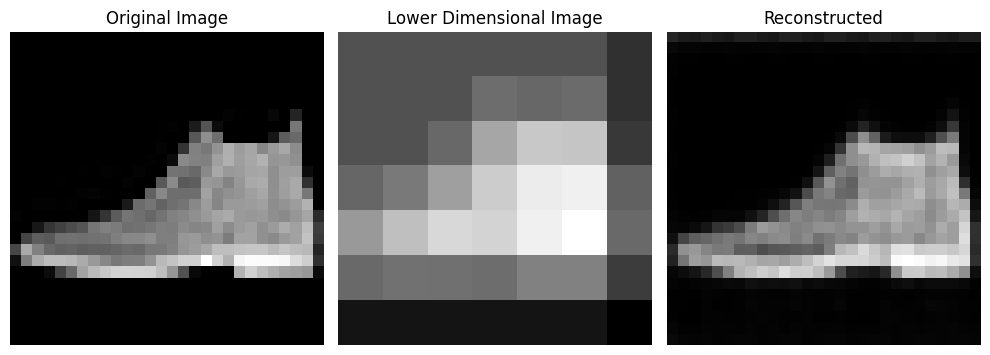

In [25]:
# Show a sample of the recontructed images

m = np.random.randint(0, len(X_test)-1)

image1 = X_test[0]
#latent_image = latent_imgs[0]
image2 = decoded_imgs[0]

fig, axes = plt.subplots(1, 3, figsize=(10, 5)) # 1 row, 2 columns, adjust figsize as needed

# Display Image 1 in the first subplot
axes[0].imshow(image1, cmap='gray') # Use a colormap suitable for your image type
axes[0].set_title('Original Image')
axes[0].axis('off') # Turn off axis labels and ticks for cleaner display

# Display Image 2 in the first subplot
axes[1].imshow(latent_image, cmap='gray') # Use a colormap suitable for your image type
axes[1].set_title('Lower Dimensional Image')
axes[1].axis('off') # Turn off axis labels and ticks for cleaner display

# Display Image 3 in the second subplot
axes[2].imshow(image2, cmap='gray') # Use a colormap suitable for your image type
axes[2].set_title('Reconstructed')
axes[2].axis('off')

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()